Quick introduction to look for how to look at the data and what the first task will require. 

SDSS J114404.76+052951.77 is a white dwarf. https://ui.adsabs.harvard.edu/abs/2015ApJ...810L..17G/abstract suggested that it had a gas disc around it due to emission from Calcium. We found that the emission is actually due to an orbiting companion, probably a brown dwarf. Your task is to measure the orbital period of the system.  

Some reading material on similar systems here https://ui.adsabs.harvard.edu/public-libraries/qIO0Ze9fQzGnpI49Ywtv4A.

In [19]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
import natsort


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

#fitting the emission lines
from astropy.modeling import models, fitting
from astropy import constants as const
from astropy import units as u
import pandas as pd
from astropy.convolution import convolve, Box1DKernel
from scipy.signal import find_peaks
from astropy.table import Table, Column, QTable
from astropy.io import fits
import matplotlib.cm as cm


#Lomb-Scargle Periodograms
from astropy.timeseries import LombScargle as LS

### Function to fit the three emission lines

In [20]:
def fitting_emission_lines(w,f,num_peaks,wavelength_range, file_num):
    ################################################################
    #### MASKING WAVELENGTH & FLUX TO ONLY INCLUDE THE PLOTTED SECTION FROM ABOVE
    ################################################################
    min_range, max_range = wavelength_range[0], wavelength_range[1]
    range_mask = (w > min_range) & (w < max_range)
    w, f = w[range_mask], f[range_mask]
    
    
    ################################################################
    #### FITTING THE CONTINUUM USING ASTROPY, FOLLOWED BY 
    #### NORMALIZING & SMOOTHING OUT THE FLUX ACCORDINGLY
    ################################################################
    fitter = fitting.LinearLSQFitter()
    n_init = models.Polynomial1D(1)
    n_fit = fitter(n_init, w, f)
    f = f / n_fit(w)
    f = convolve(f, Box1DKernel(10))
    
    
    ################################################################
    #### FINDING THE PEAKS USING SCIPY
    ################################################################
    peaks, properties = find_peaks(f, height = 0.25, distance = 2)
    w_peaks = w[peaks][(np.argpartition(f[peaks], -num_peaks)[-num_peaks:])]
    f_peaks = f[peaks][(np.argpartition(f[peaks], -num_peaks)[-num_peaks:])]


    ################################################################
    #### FITTING THE PEAKS USING ASTROPY
    ################################################################
    for i in range(num_peaks):
        if i == 0:
            model = models.Const1D(1.0) + models.Gaussian1D(1.0, w_peaks[i], 1)
        else:   
            model = model + models.Gaussian1D(1.0, w_peaks[i], 1)
        
        
    ################################################################
    #### MAKING THE FITS
    ################################################################
    fitter = fitting.LevMarLSQFitter()
    g_peak_norm = fitter(model, w, f)
    fit_info = fitter.fit_info["param_cov"]
    
    return w,f,w[peaks],f[peaks],n_fit, g_peak_norm, fit_info


### Function to make a csv of all the neccesary compiled information

In [21]:
def making_table(NIR_wavelengths,csv_path_files, fits_path_files, num_peaks,wavelength_range):
#     table_name = input("File name for the table?")
    
    
    ###############################################################
    #### ITERATING THROUGH ALL THE CSV & FITS FILES
    ################################################################
    sp = csv_path_files
    sp_f = fits_path_files

    
    ###############################################################
    #### STORING THE INFO FOR TABLE
    ################################################################    
    tracking_file_num = np.linspace(0,len(csv_path_files),len(csv_path_files))
    storing_velocities = np.zeros((len(csv_path_files),num_peaks))
    fit_error = np.zeros((len(csv_path_files),num_peaks))
    MJD = np.zeros(np.shape(sp)[0])
    file_path = []
    detections = []
    fit_peaks = np.zeros((len(csv_path_files),num_peaks))

    ################################################################
    #### GETTING WAVELENGTHS OF MAIN PEAKS, MJDS, & CALCULATING DOPPLER VELOCITIES
    ################################################################
    for i in range(0,np.shape(sp)[0]):
        ###############################################################
        #### GRABBING INFO FROM CSV FILES & FIT FUNCTION
        ################################################################ 
        s = sp[i]
        file_path.append(s.split(vispath,1)[1])
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        mod_w,mod_f,w_of_peaks,f_of_peaks, n_fit, main_peak_values,fit_e = fitting_emission_lines(w,f,num_peaks, wavelength_range,i)
        

        ###############################################################
        #### GRABBING TIME FROM CORRESPONDING FITS FILES
        ################################################################ 
        s_fits = sp_f[i]
        hdulist = fits.open(s_fits)
        hdu = hdulist[0]
        MJD_OBS, EXPTIME = hdu.header["MJD-OBS"], hdu.header["EXPTIME"]
        time = ((MJD_OBS * u.d) + (((EXPTIME/2)*u.s).to(u.d))).value
        MJD[i] = time

        
        ################################################################
        #### DETERMINING ERROR
        ################################################################
        if fit_e is not None:
            fit_error[i] = (np.sqrt(np.diag(fit_e))[2:-1:3])**2 #variance
        if fit_e is None:
            fit_error[i] = np.zeros(num_peaks)
        
        
        ################################################################
        #### EQUATION FOR DOPPLER VELOCITY:
        #### SPEED OF LIGHT * ((EMITTED - OBSERVED) / EMITTED)) = VELOCITY
        ################################################################
        peak_w = np.sort(main_peak_values.parameters[2:-1:3])
        calculated_shift = np.zeros(num_peaks)
        c = ((const.c).to(u.km/u.s)).value
        for j in range(num_peaks):
            shifted_peak = (peak_w[j] - NIR_wavelengths[j])
            doppler_velocities = c * (shifted_peak / NIR_wavelengths[j])
            storing_velocities[i][j] = doppler_velocities
            fit_peaks[i][j] = peak_w[j]
            calculated_shift[j] = shifted_peak

        ################################################################
        #### DETERMINING DETECTION
        ################################################################
        sign = np.sign(calculated_shift)
        if ((all(elements == 1 for elements in sign)) or (all(elements == -1 for elements in sign))) and ((all(abs(values) <= 30 for values in calculated_shift))):
            detections.append("Yes")
        else:
            detections.append("No")
    
    ###############################################################
    #### MAKING A DATAFRAME THAT CONTAINS THE MJD, DETECTIONS, & FILE PATH
    ################################################################    
    basic_info = pd.DataFrame()
    basic_info["MJD"] = MJD
    basic_info["Detections"] = detections
    basic_info["File Path"] = file_path

    ###############################################################
    #### MAKING A DATAFRAME TO INCLUDE DV & WEIGHTED MEAN/ERROR
    ################################################################ 
    fit_df = pd.DataFrame()
    for k in range(num_peaks):
        fit_df['DV%i' % (k+1)] = storing_velocities[:,k]
        fit_df['F%i' % (k+1)] = fit_peaks[:,k]
        fit_df['FE%i' % (k+1)] = fit_error[:,k]

        
    ###############################################################
    #### DETERMINING WEIGHTED ERROR FOR EACH DV CALCULATION
    ################################################################ 
    for l in range(num_peaks):
        maxima = fit_df['F%i' % (l+1)] - fit_df['FE%i' % (l+1)]
        max_dv = c * (NIR_wavelengths[l] - maxima)/ NIR_wavelengths[l]
        max_dv_off = max_dv - fit_df['DV%i' % (l+1)]

        minima = fit_df['F%i' % (l+1)] + fit_df['FE%i' % (l+1)]
        min_dv = c* (NIR_wavelengths[l] - minima)/ NIR_wavelengths[l]
        min_dv_off = min_dv - fit_df['DV%i' % (l+1)] 
        
        fit_df["ERROR%i" % (l+1)] = (abs(max_dv_off) + abs(min_dv_off)/2)
    
    
    ###############################################################
    #### MAKING WEIGHTED MEAN
    ################################################################ 
    for l in range(num_peaks):
        value1, value2 = fit_df['F%i' % (l+1)] + fit_df['FE%i' % (l+1)], fit_df['F%i' % (l+1)] - fit_df['FE%i' % (l+1)]
        fit_df["blah%i" % (l+1)] = ((value1 + value2)/2)**-2
        
    weighted_mean_num = (fit_df["DV1"] * fit_df["blah1"]) + (fit_df["DV2"] * fit_df["blah2"]) + (fit_df["DV3"] * fit_df["blah3"])
    weighted_err_num = (fit_df["ERROR1"] * fit_df["blah1"]) + (fit_df["ERROR2"] * fit_df["blah2"]) + (fit_df["ERROR3"] * fit_df["blah3"])
    weighted_mean_denom = fit_df["blah1"] + fit_df["blah2"] + fit_df["blah3"]
    
    fit_df["Weighted Mean"] = weighted_mean_num/weighted_mean_denom
    fit_df["Weighted Error"] = (weighted_err_num)/weighted_mean_denom

    
    fit_df = fit_df.drop(columns=["blah1","blah2","blah3"])
    fit_df = fit_df.drop(columns=["F1","F2","F3","FE1","FE2","FE3" ])  
    fit_df = fit_df.drop(columns=["ERROR1","ERROR2","ERROR3"])
    fit_df = fit_df.reindex_axis(['DV1','DV2','DV3',"Weighted Mean","Weighted Error"], axis=1)
    fit_df = fit_df.rename({'DV1': 'DV1 (km/s)', 'DV2': 'DV2 (km/s)', 'DV3': 'DV3 (km/s)'}, axis=1) 
    
    table = pd.concat([fit_df, basic_info], axis=1, sort=False)
    
    ###############################################################
    #### COMBINING BOTH DATAFRAMES TO FORM THE CSV TABLE
    ################################################################
#     t = Table.from_pandas(table)
#     making_table = t.write("%s.csv" % (table_name), format="ascii.csv", overwrite=True)
    
    return storing_velocities, MJD, detections, fit_df["Weighted Mean"], fit_df["Weighted Error"]

### Function to plot the fits & check they were accurate

In [22]:
def checking_fit_and_calcs(NIR_wavelengths,csv_path_files, fits_path_files, num_peaks,wavelength_range):
#     plot_name = input("File name for the plots?")

    
    ###############################################################
    #### GRABBING INFO FROM PREVIOUS FUNCTION
    ################################################################ 
    storing_velocities, MJD, detection, weighted_mean, weighted_error = making_table(NIR_wavelengths,csv_path_files, fits_path_files, num_peaks,wavelength_range)
    
    
    ################################################################
    #### PLOTTING TO CHECK DETECTION & FIT
    ################################################################

    sp = csv_path_files
    for i in range(0,np.shape(sp)[0]):
        ###############################################################
        #### GRABBING INFO FROM CSV FILES & FIT FUNCTION
        ################################################################ 
        s = sp[i]
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        w,f,w_peak,f_peak, n_fit, fit,fit_e = fitting_emission_lines(w,f,num_peaks, wavelength_range,i)
        
        plt.style.use("seaborn-ticks")
        plt.figure(num=None, figsize=(18, 6),facecolor='w', edgecolor='k')
#         plt.title("From File Number: %i \n Detection: %s" % (i, detection[i]), weight = "bold", size = 20)
        plt.plot(w, f, "m", markersize = 10, label = "Normalized Data")


        ################################################################
        #### PLOTTING FITS DATA
        ################################################################
        plt.axvline(NIR_wavelengths[0], color = "white", label = "NIR ${\lambda}$ values")
        plt.axvline(NIR_wavelengths[1], color = "white")
        plt.axvline(NIR_wavelengths[2], color = "white")

#         plt.plot(w_peak[(np.argpartition(f_peak, -num_peaks)[-num_peaks:])],f_peak[(np.argpartition(f_peak, -num_peaks)[-num_peaks:])],"bo", label = "scipy (each peak)")
        plt.plot(w, fit(w),"k--", lw = 3, label = "Gaussian Fit")
#         plt.plot(w, n_fit(w)+1, "m.", label = "Continuum Fit")
        plt.xlabel("Wavelength (${\AA}$)", weight = "bold", size = 15)
        plt.ylabel("Normalized Flux", weight = "bold", size = 15)
        plt.legend(loc = "best", prop = {"size" : 15})
        plt.tick_params(axis= "both", which = "major", labelsize = 13)
        plt.xlim(wavelength_range[0],wavelength_range[1])
        plt.xlim(8480,8680)
        plt.ylim(0.8,1.7)
        plt.savefig("/Users/linaflorez/Desktop/UT_TAURUS/Plots/Calcium_Fits/%i.pdf" % (i), transparent = True)
#         plt.close()
        plt.show()

    ################################################################
    #### PLOTTING TO DETERMINE IF THERE'S TIME DEPENDENCE
    ################################################################  
    index = []
    average_vel = np.zeros(len(detection))
    for i in range(0,len(detection)):
        if detection[i] == "Yes":
            index.append(i)
        
        average_vel[i] = np.mean(storing_velocities[i])

    time_x = (np.asarray(MJD)[index] * u.d).to(u.hour).value
    velocity_y = (average_vel[index])

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
    ax1.set_title("Time v Doppler Velocity \n %s" % (plot_name), weight = "bold", size = 15)
    ax1.plot(time_x, velocity_y, '.', color = "blue", markersize = 10)
    ax1.set_xlabel("Time (hours)", weight = "bold", size = 15)
    ax1.set_ylabel("Velocity (km/s)", weight = "bold", size = 15)
    ax1.tick_params("both", labelsize = 15)
    ax1.set_xlim(1406400 + 25,1406400 + 30)

    ax2.set_title("Time v Doppler Velocity", weight = "bold", size = 15)
    ax2.plot(time_x, velocity_y,  '.', color = "blue", markersize = 10)
    ax2.set_xlabel("Time (hours)", weight = "bold", size = 15)
    ax2.set_ylabel("Velocity (km/s)", weight = "bold", size = 15)
    ax2.tick_params("both", labelsize = 15)
    ax2.set_xlim(1406400 + 48,1406400 + 55)

    plt.subplots_adjust(wspace=0.25, hspace=0)
    plt.savefig("/Users/linaflorez/Desktop/UT_TAURUS/Plots/Calcium_Fits/%i.pdf" % (i), transparent = true)
    plt.close()
    #plt.show()
    
    return w_peak, f_peak

### 2019 Data Input

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


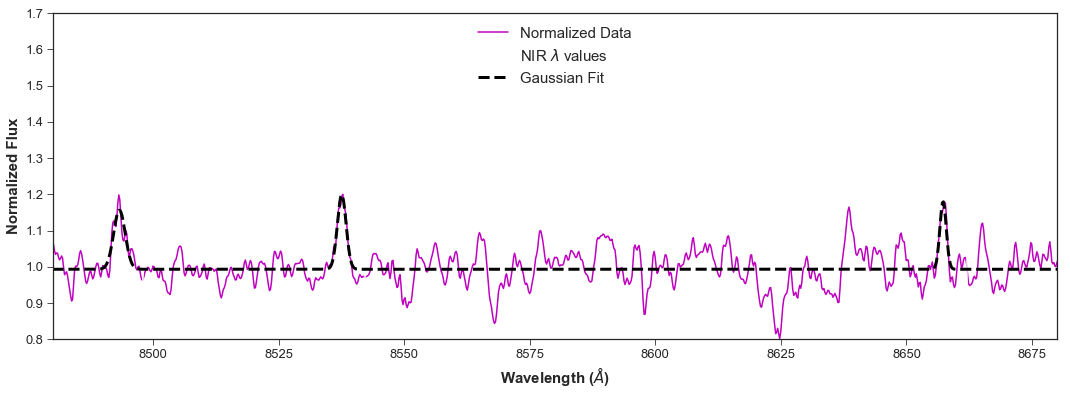

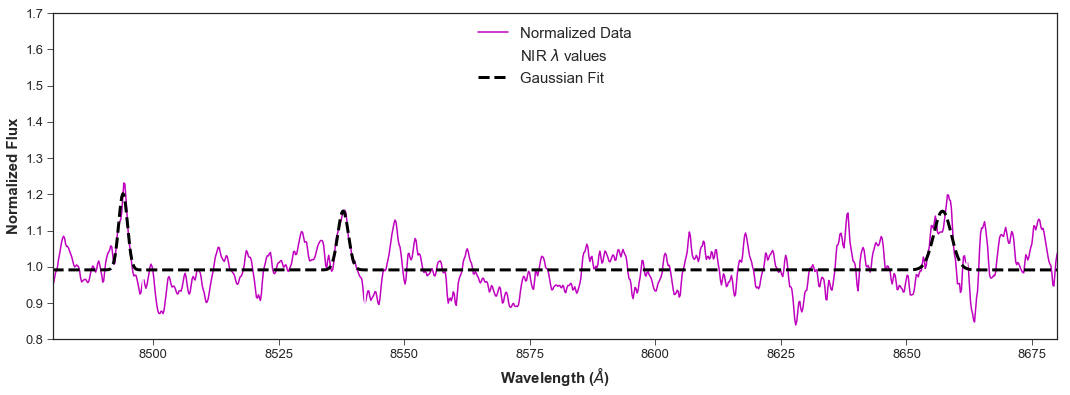

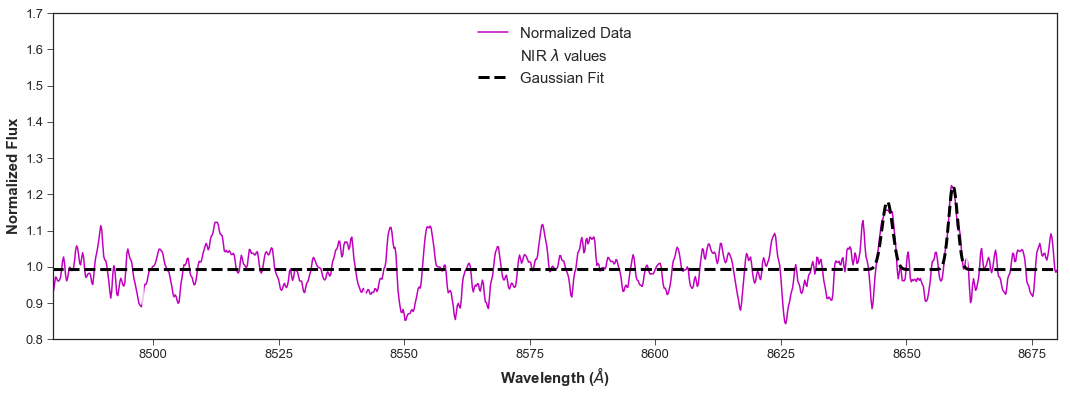

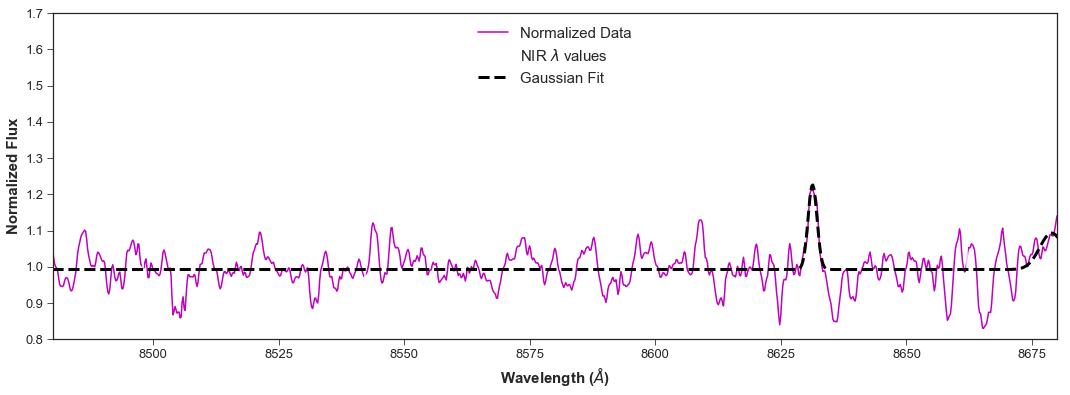

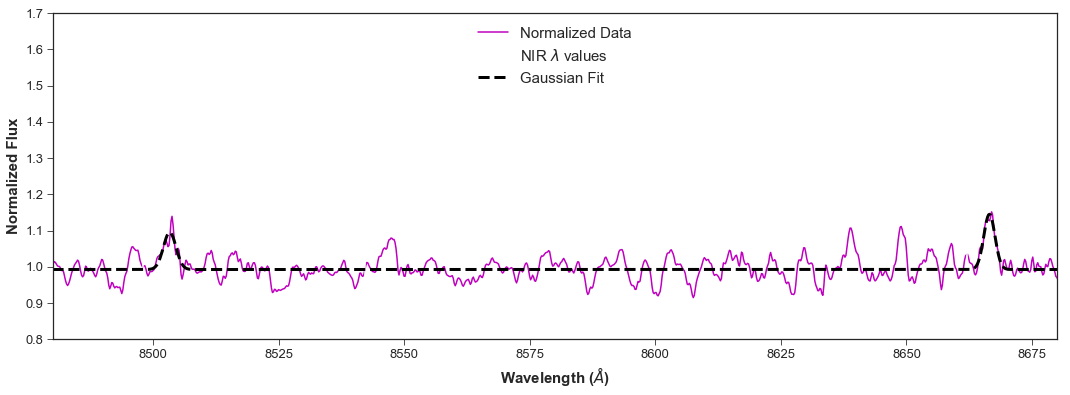

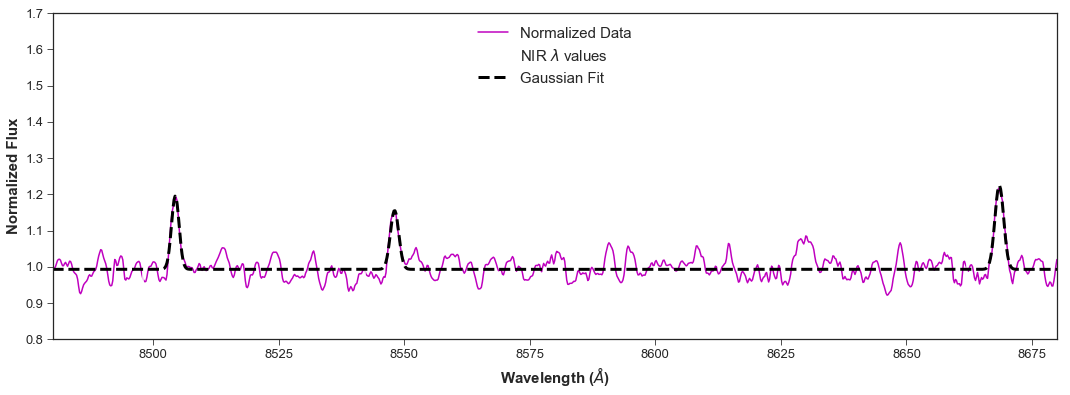

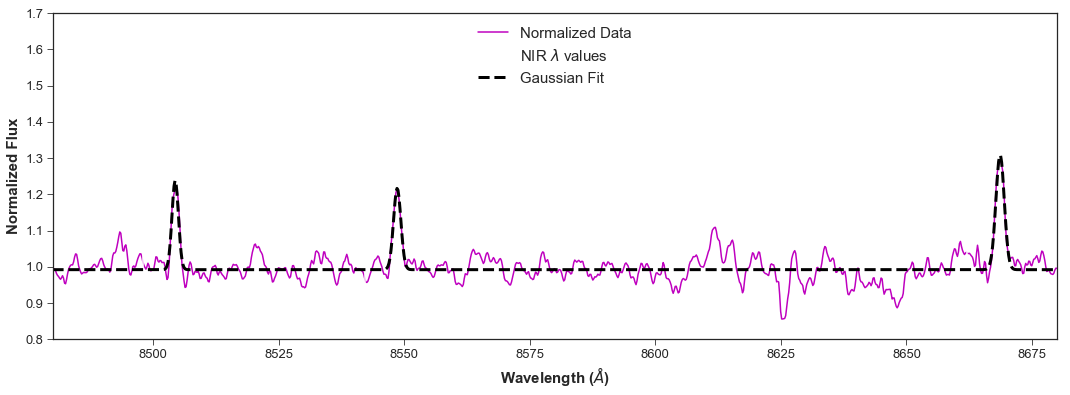

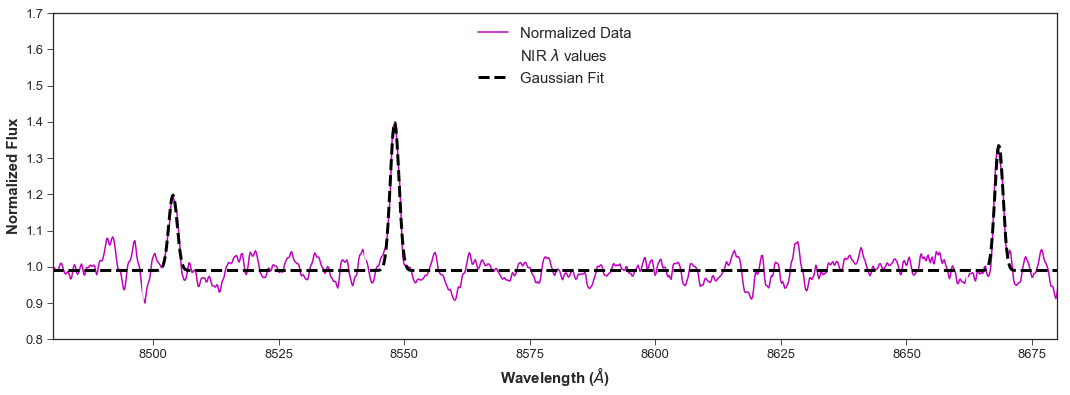

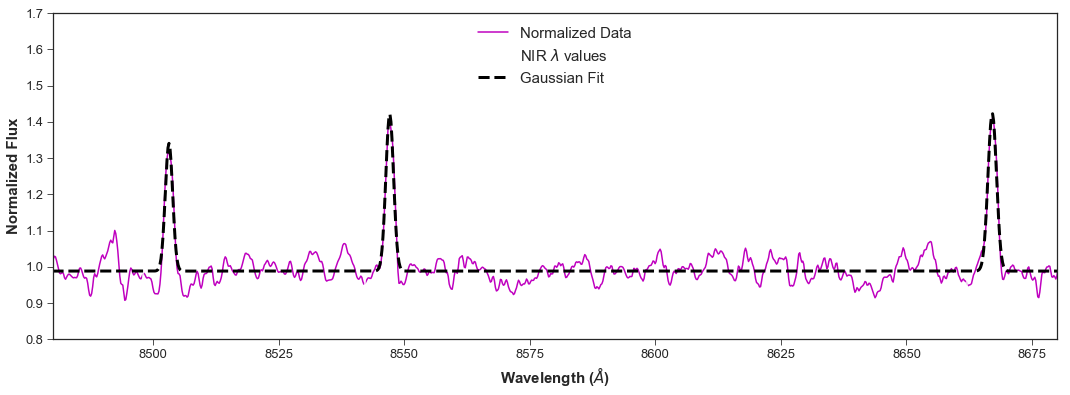

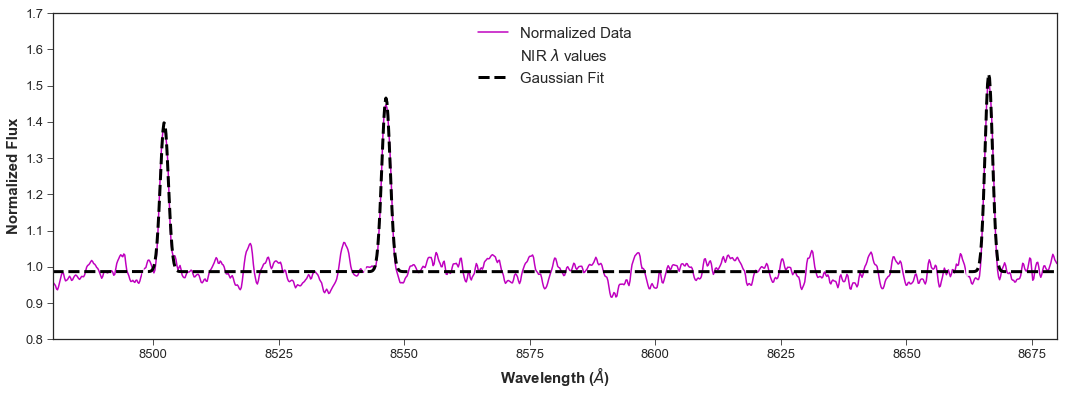

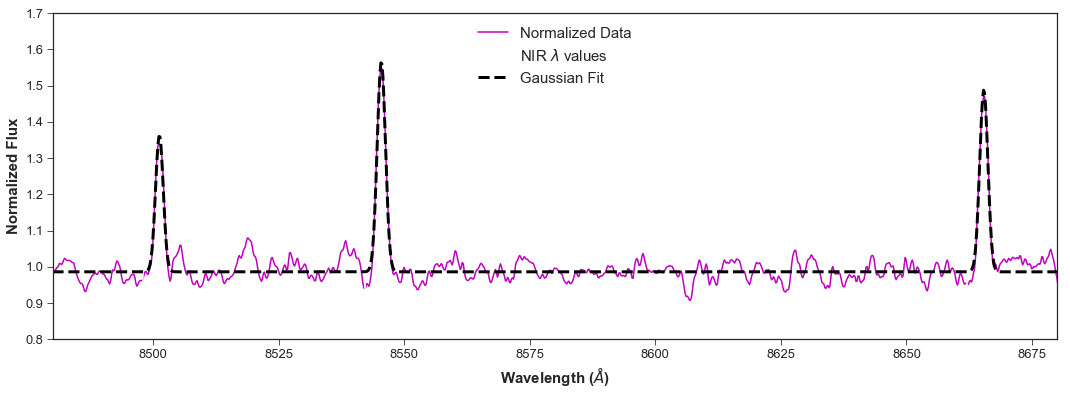

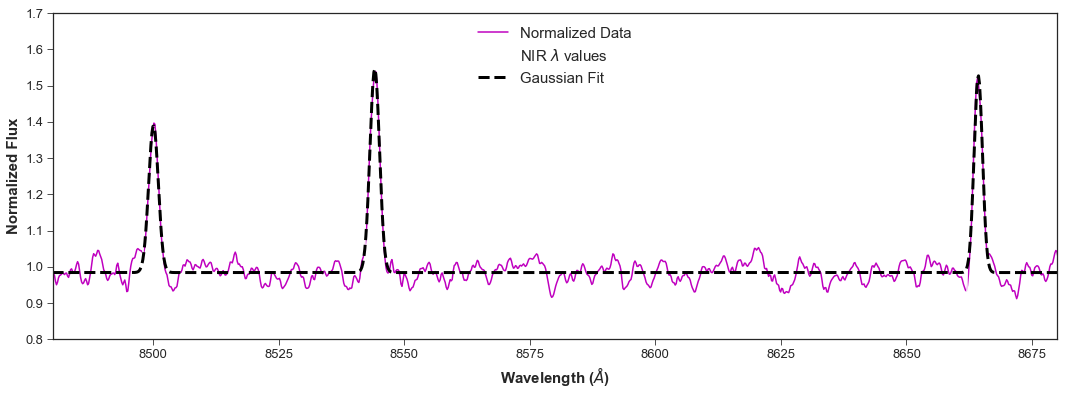

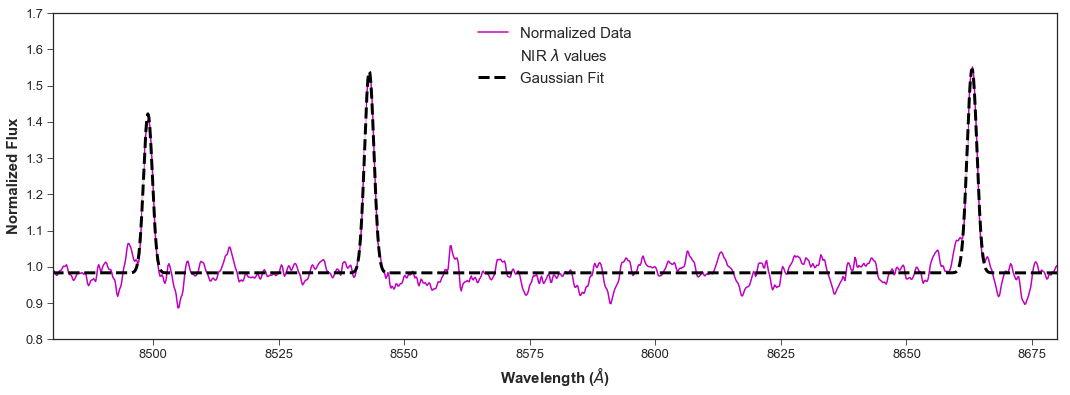

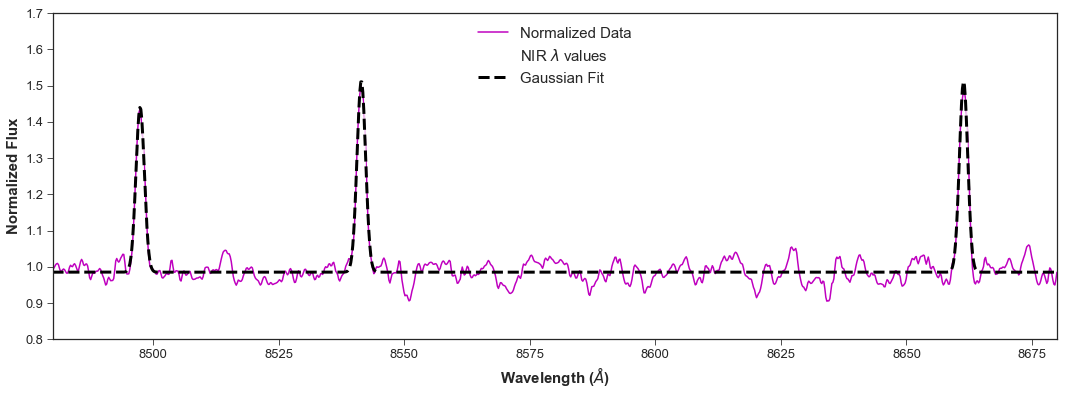

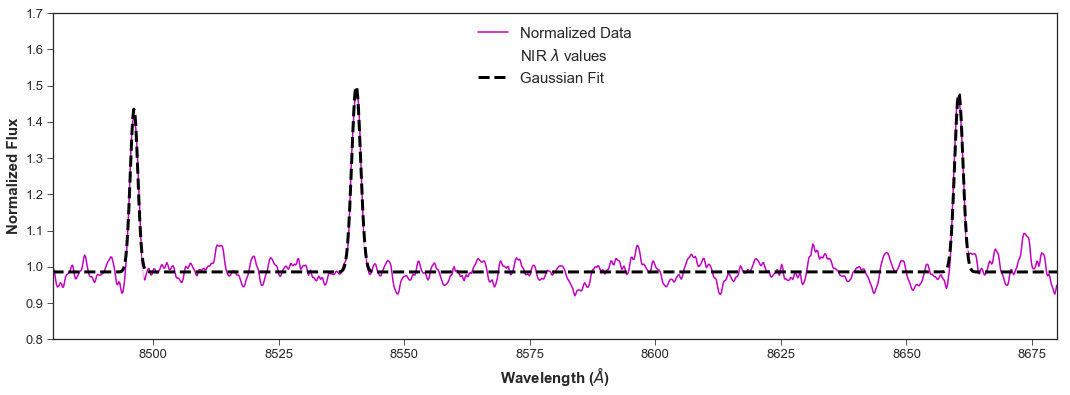

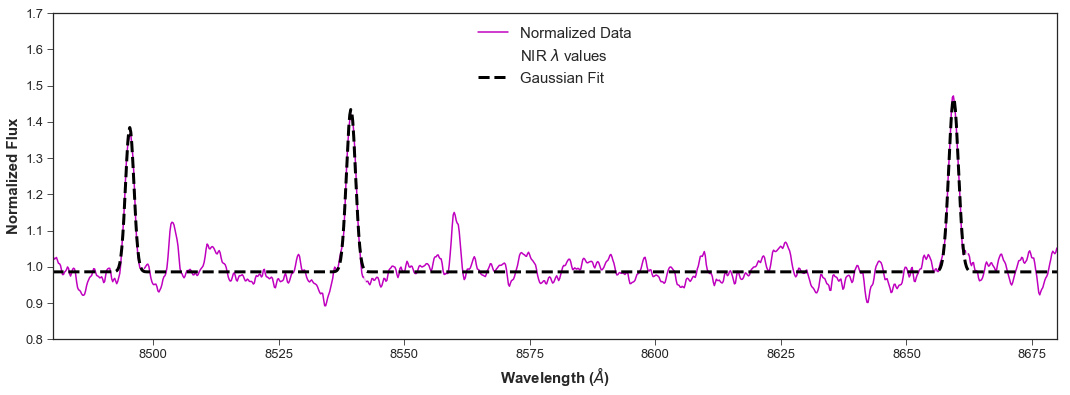

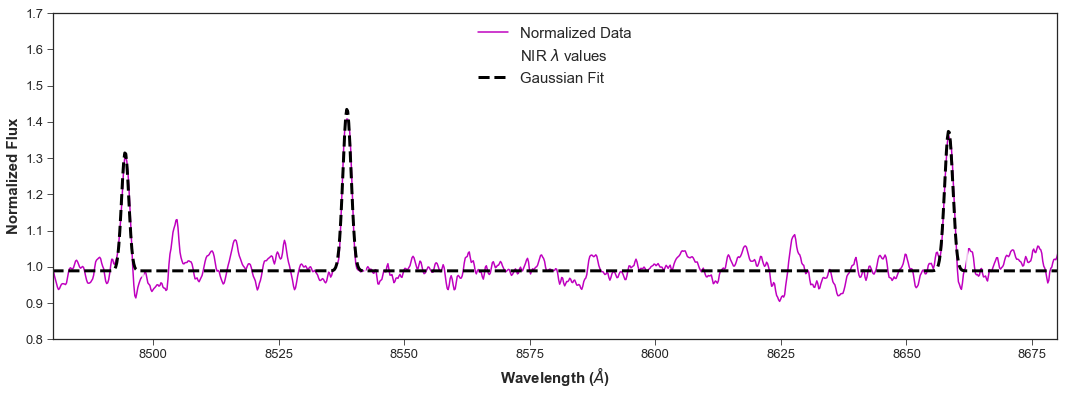

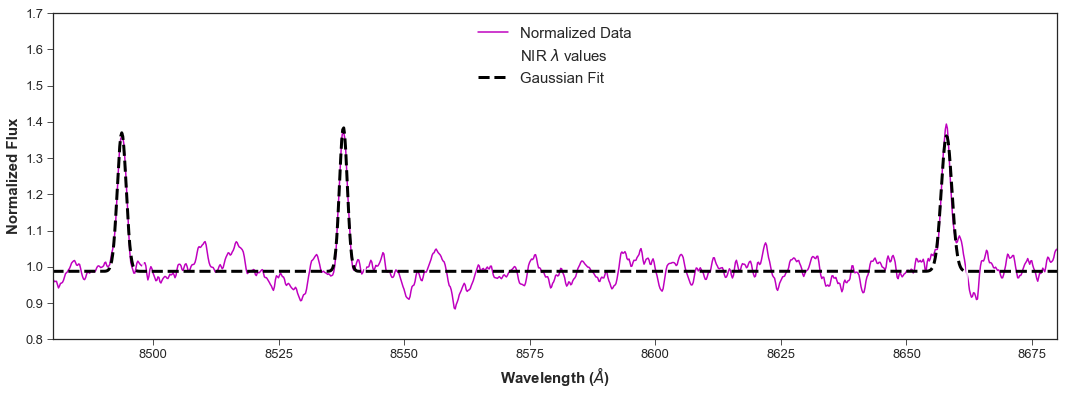

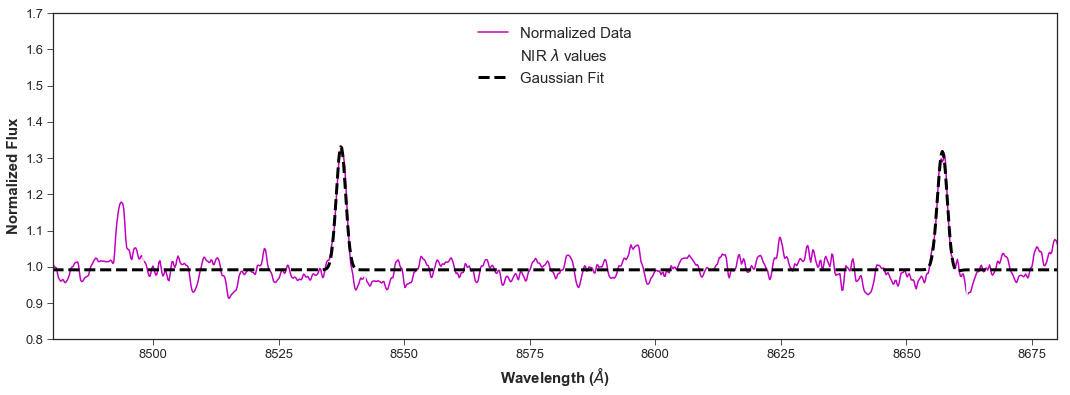

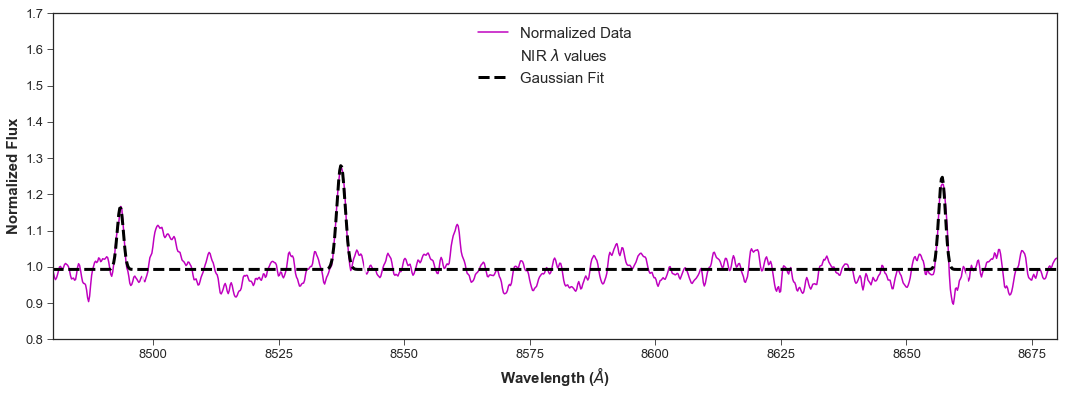

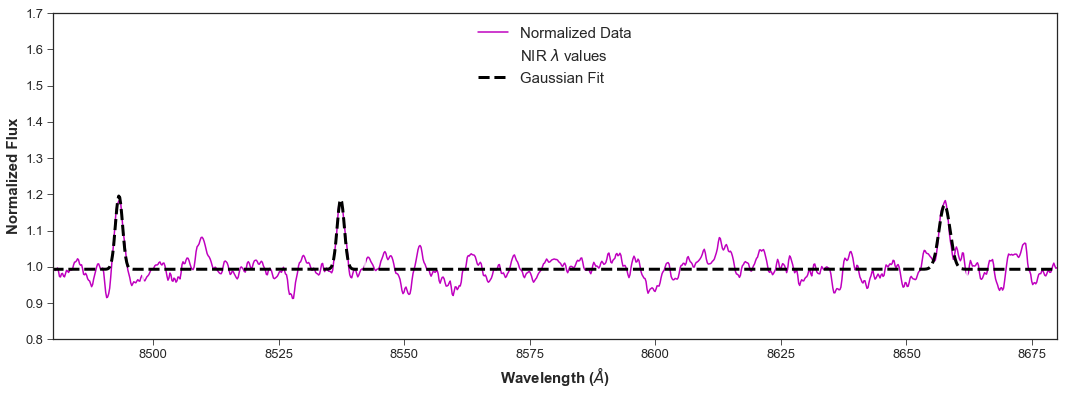

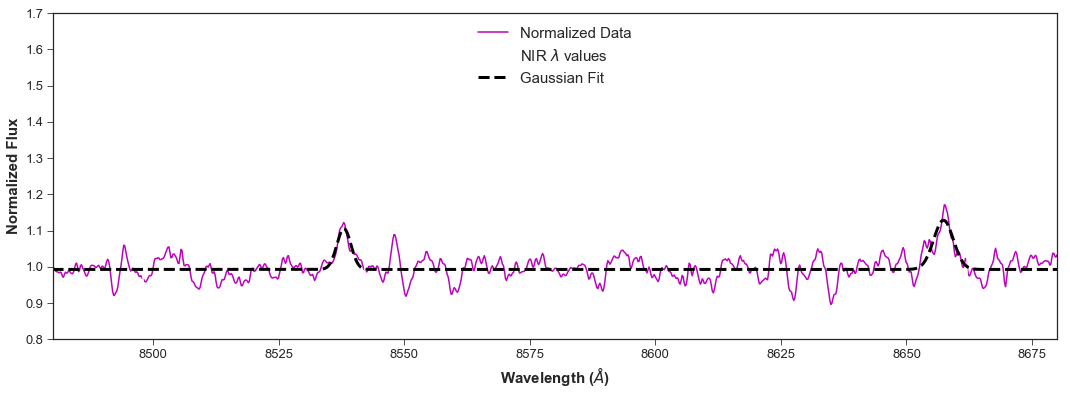

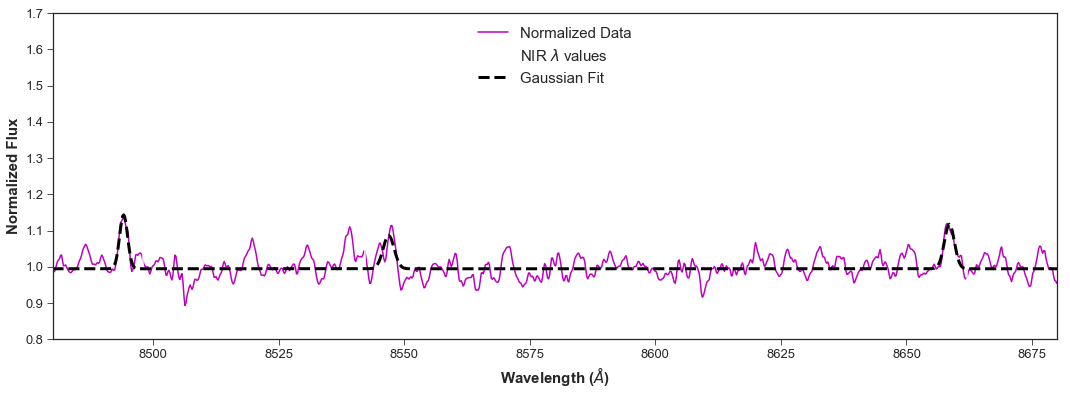

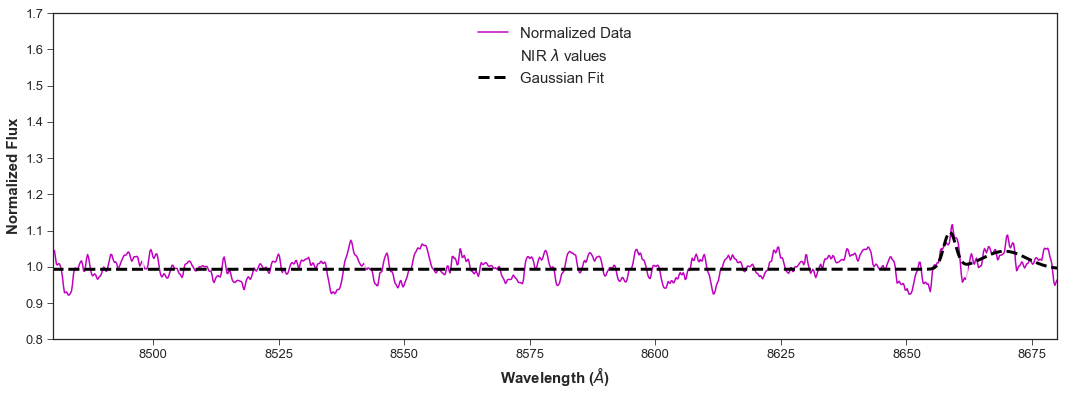

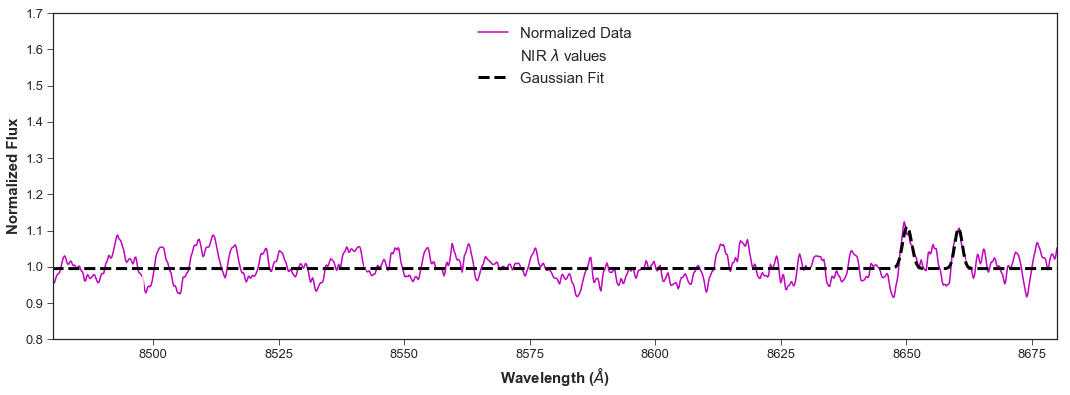

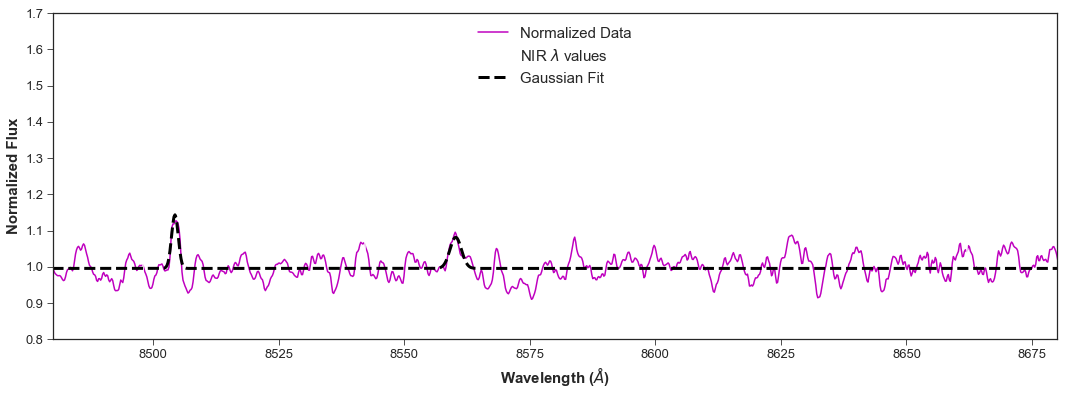

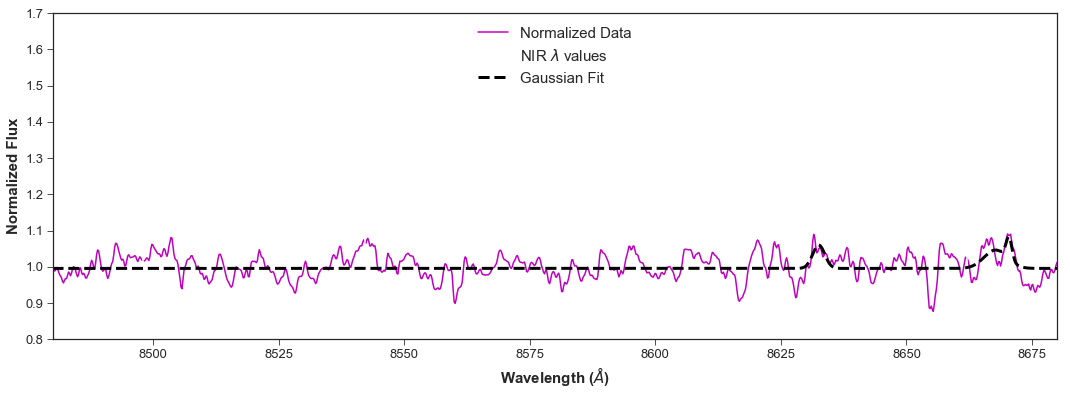

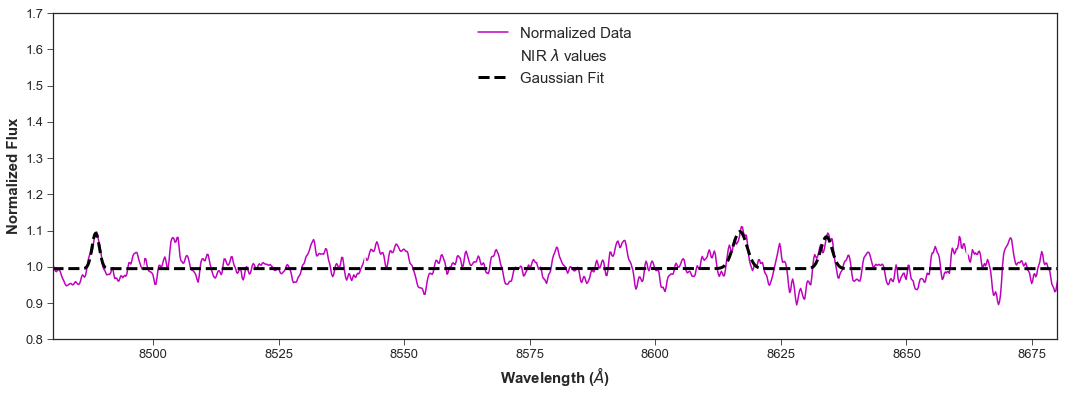

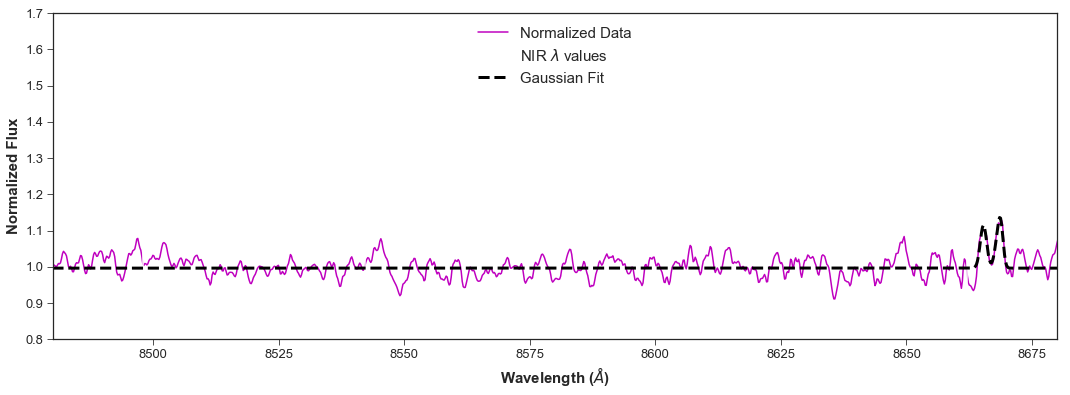

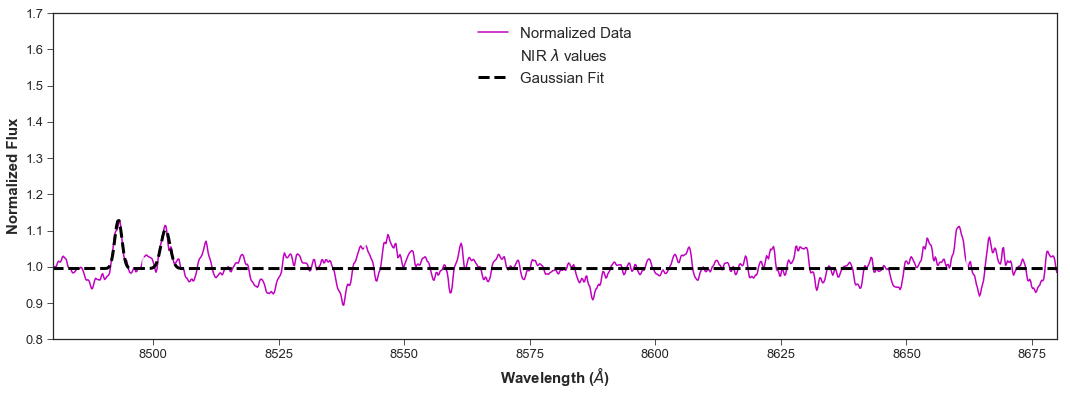

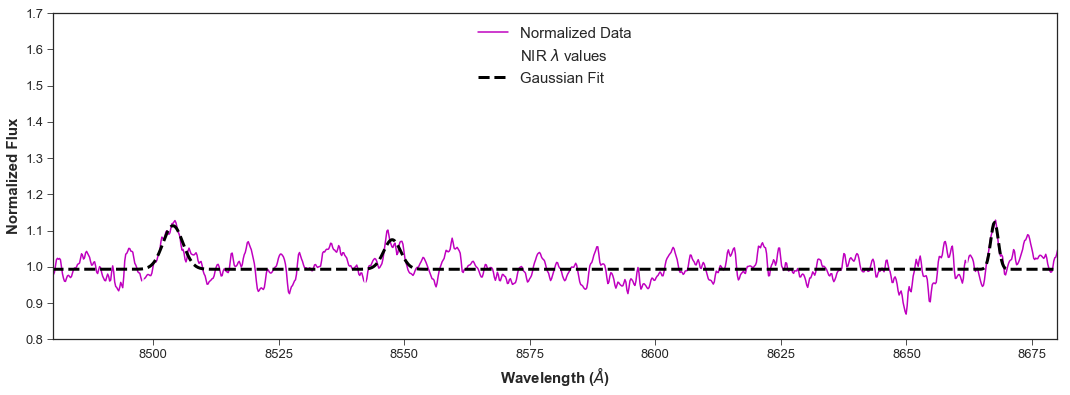

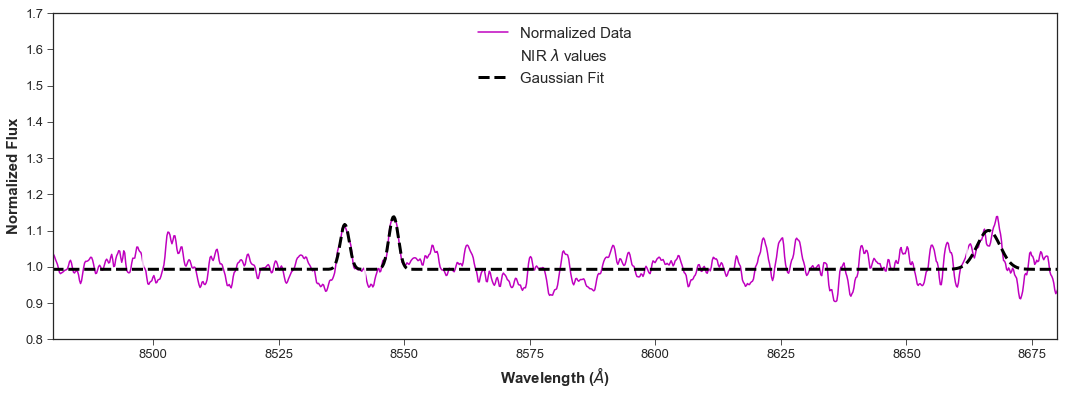

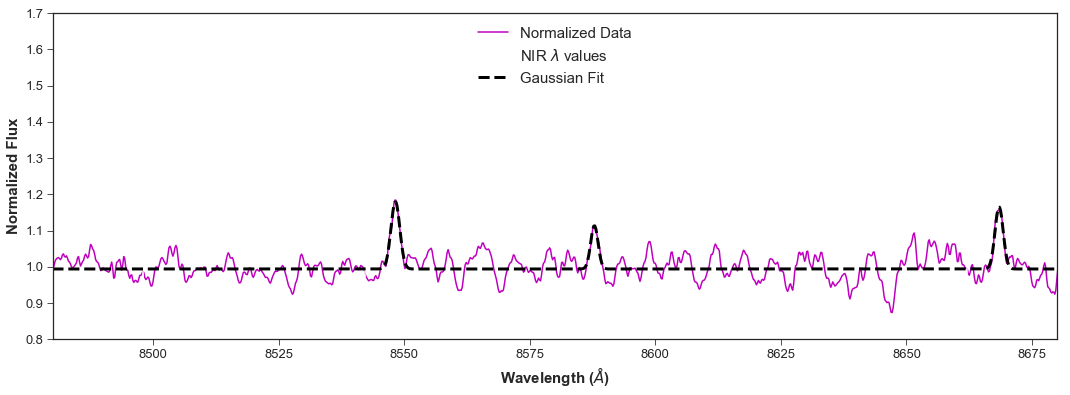

NameError: name 'plot_name' is not defined

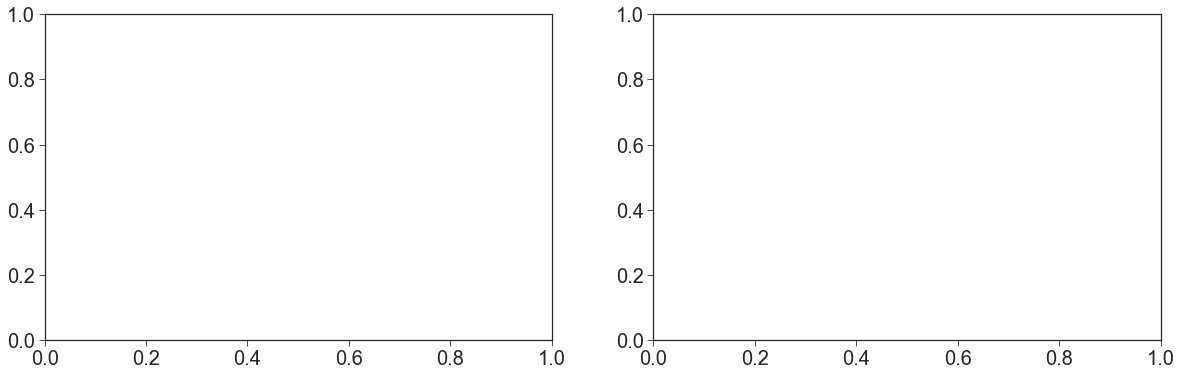

In [23]:
################################################################
#### ORIGINAL DATA
################################################################
path = "/Users/linaflorez/Desktop/UT_TAURUS/WDJ114404.76+052951.77/" #note the / on the end
#print(os.listdir(path))
vispath = path + 'VIS_notell/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
peak_wavelength_range = [(8494,8498),(8538,8542.5),(8657.75,8662.5)]
wavelength_range = (8450,8700)
NIR_wavelengths = [8498.02, 8542.09, 8662.14]
num_peaks = 3
ws,fs = checking_fit_and_calcs(NIR_wavelengths,sp_csv,sp_fits,num_peaks, wavelength_range)
#plots: OriginalData/
#table: CSV_FILES/OriginalData

# making_table(NIR_wavelengths,sp_csv, sp_fits, num_peaks,wavelength_range)

### Checking for time dependence

In [ ]:
plt.style.use("seaborn")
df = pd.read_csv("CSV_FILES/OriginalData.csv")
data = df.loc[df['Detections'] == 'Yes']
masked = data.loc[(data['MJD'] > (2.05 + 5.86e4))]
TIME = ((masked["MJD"]).values * u.d).to(u.hour)

plt.plot(TIME, masked["Weighted Mean"], "k.", markersize = 15)
plt.xlabel("Time (Hour)", weight = "bold", size = 15)
plt.xlim(49 + 1.4064e6)
plt.ylabel("Velocity (km/s)", weight = "bold", size = 15)
plt.tick_params("both", labelsize = 15)
plt.show()
print(np.max(TIME) - np.min(TIME))

In [ ]:
################################################################
#### NEW/OLD DATA
################################################################
path = "/Users/linaflorez/Desktop/Summer2019/" #note the / on the end
#print(os.listdir(path))
vispath = path + 'SDSSJ1144_old2/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
wavelength_range = (8450,8700)
NIR_wavelengths = [8498.02, 8542.09, 8662.14]
num_peaks = 3
#plots: NEW_OLD/
#table: CSV_FILES/NEW_OLD

making_table(NIR_wavelengths,sp_csv, sp_fits, num_peaks,wavelength_range)